# Nonlinear Regression: Neural Networks
### Kyle McLester

In [1]:
from copy import deepcopy as copy
from IPython.core.debugger import set_trace

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

In [2]:
tree_biomass_file = 'datasets/Appendix_S1.csv'
tree_df = pd.read_csv(tree_biomass_file)

In [3]:
tree_df

,sp,dbh,rootbiomass
0,Castanopsis eyrei,1.08,0.16
1,Castanopsis eyrei,1.85,0.15
2,Castanopsis eyrei,2.46,0.46
3,Castanopsis eyrei,2.60,1.08
4,Castanopsis eyrei,4.46,1.34
...,...,...,...
154,Schima superba,32.92,253.57
155,Schima superba,34.00,122.55
156,Schima superba,37.20,136.30
157,Schima superba,38.00,181.13


In [4]:
tree_df['sp'].unique()

array(['Castanopsis eyrei', 'Pinus massoniana', 'Schima superba'],
      dtype=object)

In [5]:
tree_type_dummies = pd.get_dummies(tree_df['sp'])
tree_type_dummies

,Castanopsis eyrei,Pinus massoniana,Schima superba
0,1,0,0
1,1,0,0
2,1,0,0
3,1,0,0
4,1,0,0
...,...,...,...
154,0,0,1
155,0,0,1
156,0,0,1
157,0,0,1


In [6]:
X = pd.concat([tree_type_dummies, tree_df['dbh']], axis=1)
X

,Castanopsis eyrei,Pinus massoniana,Schima superba,dbh
0,1,0,0,1.08
1,1,0,0,1.85
2,1,0,0,2.46
3,1,0,0,2.60
4,1,0,0,4.46
...,...,...,...,...
154,0,0,1,32.92
155,0,0,1,34.00
156,0,0,1,37.20
157,0,0,1,38.00


In [7]:
T = tree_df[['rootbiomass']].copy()  # need extra square brackets not to lose 2d shape (or dataframe)
T

,rootbiomass
0,0.16
1,0.15
2,0.46
3,1.08
4,1.34
...,...
154,253.57
155,122.55
156,136.30
157,181.13


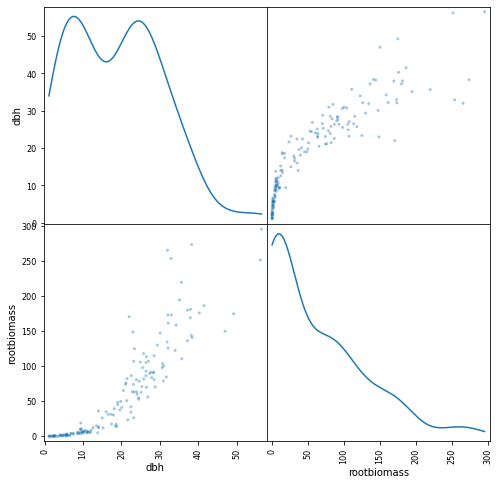

In [8]:
from pandas.plotting import scatter_matrix

scatter_matrix(tree_df, alpha=0.4, figsize=(8,8), diagonal='kde',);

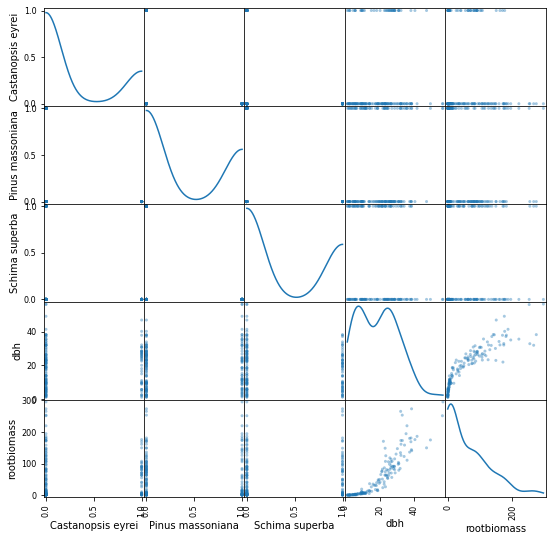

In [9]:
Data = pd.concat([X, T], axis=1)
scatter_matrix(Data, alpha=0.4, figsize=(9,9), diagonal='kde');

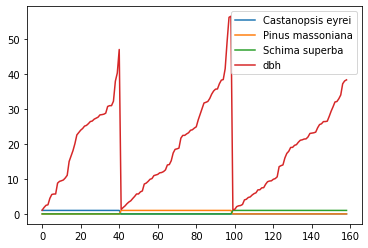

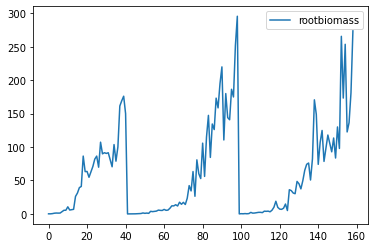

In [10]:
X.plot()
T.plot()

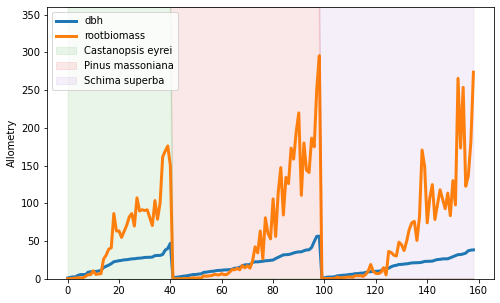

In [11]:
scale_y_axis = 1.2
# Find the max y-value and scale it
max_y_value = np.round(np.max(Data.max().values), decimals=-2) * scale_y_axis 

ax = tree_df.plot(linewidth=3, figsize=(8,5)) # plots all features 
(tree_type_dummies * max_y_value).plot.area(ax=ax, alpha=0.1) # colors in graph
plt.ylim([0, max_y_value]) # sets the y-axis min and max values
plt.ylabel("Allometry"); # the ; here surpresses output

In [12]:
# now partition the data 

""" partitioning data

    parameters
    -----------
    X        numpy array
             input data to partition
    T        numpy array
             target labels to partition
    raito    list
             list of ratios for partitions (should be summed to 1) 
             the number of return pairs are different
    return
    -------
    
    Xs       list of numpy arrays
    
    Ts       list of numpy arrays
"""
def partition(X, T, ratio=[0.8, 0.2]): 
    
    # Checks to make sure ratio sums to 1
    assert(np.sum(ratio) == 1)
    
    # Store the number of data samples 
    N = X.shape[0]

    # change the 1d array to 2d if need
    if len(T.shape) == 1:
        T = T.reshape((N,1))
    
    # Shuffle the data indices 
    idxs = np.random.permutation(N)
        
    Xs = []
    Ts = []
    i = 0  # first index to zero
    for k, r in enumerate(ratio):
         # Number of rows that corresponds to kth element in ratios
        nrows = int(round(N * r)) 
        
        # print (i, nrows)
        # If we are on the last ratio simply use the remaining data samples
        if k == len(ratio)-1:
            Xs.append(X[idxs[i:], :])
            Ts.append(T[idxs[i:], :])
        else:
            Xs.append(X[idxs[i:i+nrows], :])
            Ts.append(T[idxs[i:i+nrows], :])
        
        i += nrows
    
    return Xs, Ts

In [13]:
def partition_data():
    """Partition data into train and test splits."""
    global Xtrain, Xtest, Ttrain, Ttest
    data, targets = partition(copy(X.values), copy(T.values))
    # Fill in the right had side of the assignments below
    Xtrain, Xtest = data
    # Fill in the right had side of the assignments below
    Ttrain, Ttest = targets

In [14]:
partition_data()
print("Train data shape: {}".format(Xtrain.shape))
print("Train target shape: {}".format(Ttrain.shape))
print("Test data shape: {}".format(Xtest.shape))
print("Test target shape: {}".format(Ttest.shape))

Train data shape: (127, 4)
Train target shape: (127, 1)
Test data shape: (32, 4)
Test target shape: (32, 1)


In [15]:
N = X.shape[0] # Number of data samples
D = X.shape[1] # Number of data features
Ntrain = Xtrain.shape[0] # Number of train data samples
Ntest = Xtest.shape[0] # Number of test data samples
print("N = {} data samples".format(N))
print("D = {} data features".format(D))
print("Ntrain = {} training data samples".format(Ntrain))
print("Ntest = {} testing data samples".format(Ntest))

N = 159 data samples
D = 4 data features
Ntrain = 127 training data samples
Ntest = 32 testing data samples


In [16]:
X.describe()

,Castanopsis eyrei,Pinus massoniana,Schima superba,dbh
count,159.000000,159.000000,159.000000,159.000000
mean,0.257862,0.364780,0.377358,19.018239
std,0.438840,0.482889,0.486257,12.210006
min,0.000000,0.000000,0.000000,1.080000
25%,0.000000,0.000000,0.000000,8.800000
50%,0.000000,0.000000,0.000000,19.020000
75%,1.000000,1.000000,1.000000,27.215000
max,1.000000,1.000000,1.000000,56.500000


In [17]:
mu = np.mean(Xtrain, axis=0)
mu

array([ 0.26771654,  0.35433071,  0.37795276, 19.03173228])

In [18]:
sigma = np.std(Xtrain, axis=0)
sigma

array([ 0.44276901,  0.47831   ,  0.48487573, 12.42724864])

In [19]:
print("Xtrain shape: {}".format(Xtrain.shape))
print("mu shape: {}".format(mu.shape))
print("sigma shape: {}".format(sigma.shape))

Xtrain shape: (127, 4)
mu shape: (4,)
sigma shape: (4,)


In [20]:
Xstrain = Xtrain.copy() 

Xstrain[:, 3] = (Xtrain[:, 3] - mu[3]) / sigma[3]

In [21]:
pd.DataFrame(Xstrain).describe()

,0,1,2,3
count,127.000000,127.000000,127.000000,1.270000e+02
mean,0.267717,0.354331,0.377953,-2.797412e-17
std,0.444523,0.480204,0.486796,1.003960e+00
min,0.000000,0.000000,0.000000,-1.444546e+00
25%,0.000000,0.000000,0.000000,-8.072368e-01
50%,0.000000,0.000000,0.000000,-3.474078e-02
75%,1.000000,1.000000,1.000000,7.196499e-01
max,1.000000,1.000000,1.000000,3.015009e+00


In [22]:
X1strain = np.hstack((np.ones((Ntrain, 1)), Xstrain))
X1strain[:5, :]

array([[ 1.        ,  0.        ,  0.        ,  1.        ,  1.0531911 ],
       [ 1.        ,  0.        ,  0.        ,  1.        , -1.3383278 ],
       [ 1.        ,  0.        ,  1.        ,  0.        , -0.65032354],
       [ 1.        ,  0.        ,  0.        ,  1.        ,  0.5414125 ],
       [ 1.        ,  0.        ,  1.        ,  0.        ,  0.47220973]])

In [23]:
print("Normalized Xtrain with bias added shape: {}".format(X1strain.shape,))
print("Ttrain shape: {}".format(Ttrain.shape))

Normalized Xtrain with bias added shape: (127, 5)
Ttrain shape: (127, 1)


In [24]:
X1s_inverse = np.linalg.pinv(X1strain.T @ X1strain)
w = X1s_inverse @ X1strain.T @ Ttrain
w

array([[45.88182305],
       [ 8.15769476],
       [ 8.81376894],
       [28.91035935],
       [64.92946708]])

In [25]:
Ytrain_ls = X1strain @ w

In [26]:
def plot_fit(Y, T, title=None):
    """ Plot the passed predictions and targets while also computing
        and printing the RMSE.
    """
    plt.plot(T, label="target")
    plt.plot(Y, linewidth=3, label="prediction")
    plt.legend()
    plt.ylabel("Allometry")
    plt.xlabel("Samples")
    plt.title(title)
    # RMSE
    rmse = np.sqrt(np.mean((Y - T)**2))
    print("RMSE: {}".format(rmse))

RMSE: 29.14594446154451


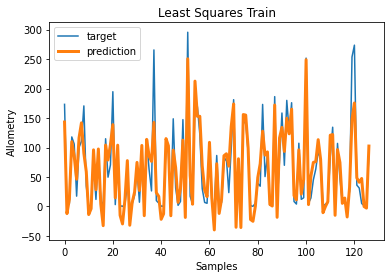

In [27]:
plot_fit(Ytrain_ls, Ttrain, title="Least Squares Train")

In [28]:
Xstest = Xtest.copy() 

# Standardize testing data
Xstest[:, 3] = (Xtest[:, 3] - mu[3]) / sigma[3]
X1stest = np.hstack((np.ones((Ntest, 1)), Xstest))

# Make predictions for testing data using learning weights
Ytest_ls = X1stest @ w

RMSE: 28.21955149068106


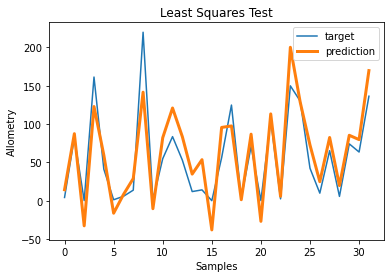

In [29]:
plot_fit(Ytest_ls, Ttest, title="Least Squares Test")

# Apply Nonlinear Regression: Neural Networks

It's finally time to try out our nonlinear neural network algorithm. Since we are using a simple one layer neural network we will only have two weights, input weights $V$ and output weights $W$.

## Variables 

Here is a list of the variables,  shapes, and their description.

- $X : N \times D$ - Input Data without bias
    - $N$ is the number of data samples
    - $D$ is the number of features
- $X1 : N \times (D+1)$ - Input data with bias
    - $(D+1)$ is the number of features plus bias
- $V : (D+1) \times G$ - Input weights
    - Note: $G$ is the number of hidden units
- $Z : N \times G$ - First layer output
    - Note: Activation function is applied here
- $Z1 : N \times (G+1)$ - First layer output with bias
    - $(G+1)$ is the number of hidden units plus bias
- $W : (G+1) \times K$ - Output weights
    - $K$ is the number of outputs (for regression this is 1 and for classification this your number of classes)
- $Y : N \times K$ - Predictions
- $T : N \times K$ - Targets

## Forward Pass Steps

Recall the following steps for making a prediction, also called the forward pass, from the class notes.

1. Calculate first layer output by taking the dot product between the inputs $X1$ and input weights $V$. Then apply the activation function $\tanh$. 
$$Z = \tanh(X1 \cdot V)$$
2. Add bias to $Z$ to get $Z1$
3. Make your predictions by taking the dot product between the output of the first layer $Z1$ and the output weights $W$.
$$Y = Z1 \cdot W$$

## Backward Pass Equations

Recall the backward pass weight updates for $V$ and $W$ from the class notes.

$$ V \leftarrow V + \frac{\rho_v}{N*K}*{X1}^T \cdot ( (T - Y) \cdot W^T \odot (1 - Z^2) )$$

Here $N$ and $K$ are scalars and $\rho_v$ is our learning rate for our input weights $V$. In addition, $X1$ is our input data with bias added, $T$ is our target, $Y$ is our predictions, $W$ is the output weights, and $Z$ is the output of the first layer with the activation function applied. **Recall, that we remove the bias from $W$ for this update as we only take into account the bias for the current weight we are updating! (In the case, since we updating $V$, we only care about the bias for input weight $V$.)**

$$ W \leftarrow W + \frac{\rho_w}{N*K}*{Z1}^T \cdot (T - Y)$$

Here $N$ and $K$ are scalars and $\rho_w$ is our learning rate for our output weights $W$. In addition, $T$ is our target, $Y$ is our predictions, $Z1$ is the output of the first layer with the activation function applied and bias added. 

**Note that $\cdot$ refers to the dot product, $\odot$ refers to the element-wise multiplication, and $*$ refers to scalar multiplication.**

In [30]:
def addOnes(A):
    """Adds bias to passed data"""
    return np.insert(A, 0, 1, axis=1)

In [31]:
# N, D, Ntrain, and Ntest were all previously set
# Now, set the number of outputs, which will be one since we are preforming regression
K = Ttrain.shape[1] if len(Ttrain.shape) == 2 else 1

# Set parameters of neural network
hidden_units = 5

rho_v = 0.01
rho_w = 0.01

rho_v_scaled = rho_v / (Ntrain*K)
rho_w_scaled = rho_w / (Ntrain*K)

# Number of graident descent steps to take when searching for a minimum in mean-squared-error space
steps = 30000

###########################################################################
# Initialize weights to uniformly distributed values between small normally-distributed between -0.1 and 0.1
V = 0.1*2*(np.random.uniform(size=(D+1,hidden_units))-0.5)
W = 0.1*2*(np.random.uniform(size=(1+hidden_units,K))-0.5)

###########################################################################
# collect training and testing errors for plotting
errorTrace = np.zeros((steps,2))

fig = plt.figure(figsize=(10,8))
for s in range(steps):
    
    # Forward pass on training data

    Z = np.tanh(X1strain @ V)

    Z1 = addOnes(Z)

    Ytrain = Z1 @ W

    # Error in output
    error = Ttrain - Ytrain

    # Backward pass - the backpropagation and weight update steps

    V = V + rho_v_scaled * X1strain.T @ ((error @ W[1:, :].T) * (1-Z**2))

    W = W + rho_w_scaled * Z1.T @ error        

    # Train error trace for plotting later
    errorTrace[s,0] = np.sqrt(np.mean((error**2)))
    
    # Test error trace for plotting later
    Ytest = addOnes(np.tanh(X1stest @ V)) @ W  # Forward pass in one line!
    errorTrace[s,1] = np.sqrt(np.mean((Ytest-Ttest)**2))

<Figure size 720x576 with 0 Axes>

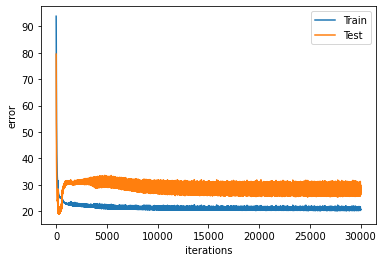

In [32]:
plt.plot(errorTrace)
plt.legend(('Train','Test'))
plt.xlabel("iterations")
plt.ylabel("error");

RMSE: 20.430833744908927


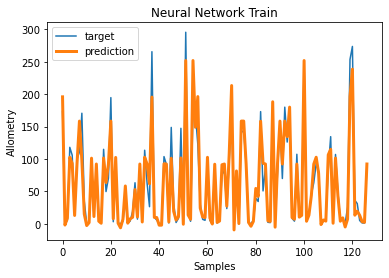

In [33]:
Ytrain_nn = addOnes(np.tanh(X1strain @ V)) @ W  #!! Forward pass in one line

plot_fit(Ytrain_nn, Ttrain, title="Neural Network Train")

RMSE: 28.859316241283455


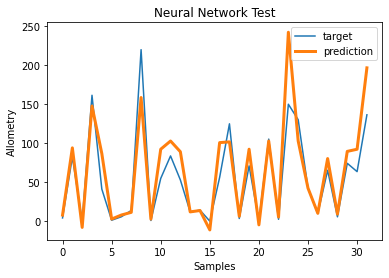

In [34]:
Ytest_nn = addOnes(np.tanh(X1stest @ V)) @ W  #!! Forward pass in one line

plot_fit(Ytest_nn, Ttest, title="Neural Network Test")

RMSE: 28.21955149068106


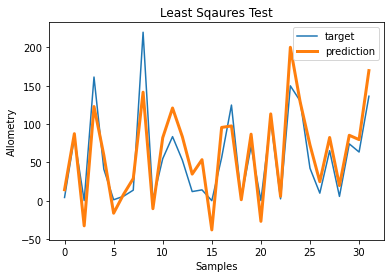

In [35]:
# linear regression: least sqaures
plot_fit(Ytest_ls, Ttest, title="Least Sqaures Test")

RMSE: 28.859316241283455


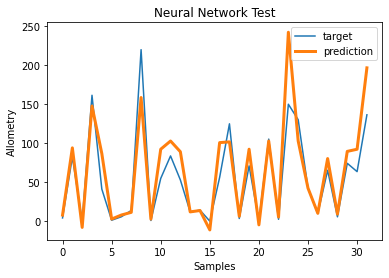

In [36]:
# nonlinear regression: neural network
plot_fit(Ytest_nn, Ttest,  title="Neural Network Test")